In [46]:
# Import libraries here
import gzip
import json
import pickle

import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline

In [47]:
# Load data file

with gzip.open("taiwan-bankruptcy-data.json.gz", "r" ) as f:
    taiwan_data = json.load(f)

print(type(taiwan_data))

<class 'dict'>


In [48]:
taiwan_data_keys = taiwan_data.keys()
print(taiwan_data_keys)

dict_keys(['schema', 'metadata', 'observations'])


In [49]:
n_companies = len(taiwan_data["observations"])
print(n_companies)

6137


In [50]:
n_features = len(taiwan_data["observations"][0])
print(n_features)

97


In [51]:
# Create wrangle function
def wrangle(filename):
    with gzip.open(filename, "r") as f:
        data = json.load(f)

    #dict to dataframe, set index
    df = pd.DataFrame().from_dict(data["observations"]).set_index("id")
    return df


In [52]:
df = wrangle("taiwan-bankruptcy-data.json.gz")
print("df shape:", df.shape)
df.head()

df shape: (6137, 96)


,bankrupt,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95
id,,,,,,,,,,,,,,,,,,,,,
1,True,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
2,True,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
3,True,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
4,True,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
5,True,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [53]:
df.isna().columns
df.isna().sum()

,0
bankrupt,0
feat_1,0
feat_2,0
feat_3,0
feat_4,0
...,...
feat_91,0
feat_92,0
feat_93,0
feat_94,0


In [54]:
nans_by_col = pd.Series( df.isna().sum(),index=df.isna().columns)
print("nans_by_col shape:", nans_by_col.shape)
nans_by_col.head()

nans_by_col shape: (96,)


,0
bankrupt,0
feat_1,0
feat_2,0
feat_3,0
feat_4,0


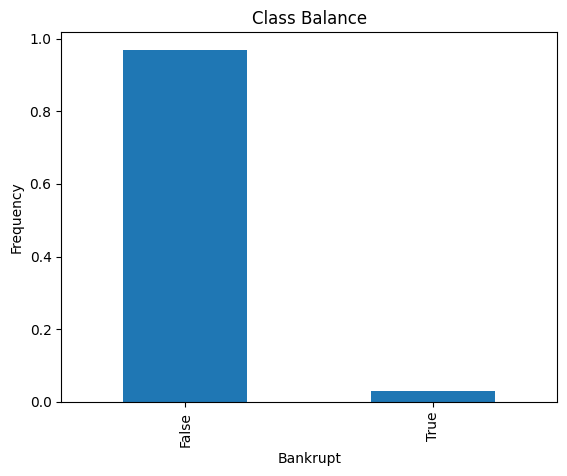

In [55]:
# Plot class balance
df["bankrupt"].value_counts(normalize = True)

fig, ax = plt.subplots()

df["bankrupt"].value_counts(normalize = True).plot(kind = "bar")
plt.xlabel("Bankrupt")
plt.ylabel("Frequency")
plt.title("Class Balance");

In [56]:
#split the dataset
target = "bankrupt"
X = df.drop(columns = [target])
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (6137, 95)
y shape: (6137,)


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4909, 95)
y_train shape: (4909,)
X_test shape: (1228, 95)
y_test shape: (1228,)


In [58]:
#resampling because of imbalance classes
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # 2:1 ratio (False:True)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("X_train_smote shape:", X_train_over.shape)
X_train_smote.head()

X_train_smote shape: (9512, 95)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95
0,0.535855,0.599160,0.594411,0.627099,0.627099,0.999220,0.797686,0.809591,0.303518,0.781865,...,0.834091,0.022025,0.624364,0.627101,0.841977,0.275384,0.026791,0.565158,1,0.147943
1,0.554136,0.612734,0.595000,0.607388,0.607388,0.999120,0.797614,0.809483,0.303600,0.781754,...,0.840293,0.002407,0.624548,0.607385,0.842645,0.276532,0.026791,0.565158,1,0.062544
2,0.549554,0.603467,0.599122,0.620166,0.620166,0.999119,0.797569,0.809470,0.303524,0.781740,...,0.840403,0.000840,0.624010,0.620163,0.842873,0.277249,0.026800,0.565200,1,0.047929
3,0.543801,0.603249,0.606992,0.622515,0.622515,0.999259,0.797728,0.809649,0.303510,0.781930,...,0.831514,0.006176,0.626775,0.622513,0.842989,0.280013,0.026839,0.565375,1,0.028386
4,0.498659,0.562364,0.546978,0.603670,0.603670,0.998904,0.797584,0.809459,0.304000,0.781713,...,0.811988,0.004256,0.623674,0.603669,0.841105,0.277628,0.026897,0.565618,1,0.043080


In [59]:
#baseline model
acc_baseline = y_train.value_counts(normalize = True)
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: bankrupt
False    0.9688
True     0.0312
Name: proportion, dtype: float64


In [60]:
#Building model -Gradient Boosting
clf_gb = make_pipeline(SimpleImputer(), GradientBoostingClassifier())

In [61]:

params_gb = {
    "simpleimputer__strategy": ["mean", "median"],
    "gradientboostingclassifier__n_estimators":range(20, 31, 5),
    "gradientboostingclassifier__max_depth": range(2, 5)
}
params_gb

{'simpleimputer__strategy': ['mean', 'median'],
 'gradientboostingclassifier__n_estimators': range(20, 31, 5),
 'gradientboostingclassifier__max_depth': range(2, 5)}

In [62]:
model_gb_sm = GridSearchCV(
    clf_gb,
    param_grid=params_gb,
    cv = 5,
    n_jobs= -1,
    verbose= 1)

In [63]:
# Fit model to over-sampled training data
model_gb_sm.fit(X_train_smote, y_train_smote) # 2 imp strategy, 3 n_estimators, 3 max_depth, 5 cv

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [64]:
results_gb = pd.DataFrame(model_gb_sm.cv_results_)
results_gb.sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16,10.938883,0.098307,0.009767,0.001972,4,30,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.935529,0.946741,0.941836,0.951647,0.950210,0.945193,0.005897,1
17,10.781121,0.281789,0.015420,0.010056,4,30,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.934828,0.946741,0.941836,0.951647,0.950210,0.945053,0.006129,2
14,9.174079,0.318465,0.009141,0.000480,4,25,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.934128,0.939033,0.940434,0.946041,0.941795,0.940286,0.003871,3
15,9.160769,0.241385,0.010258,0.002022,4,25,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.933427,0.939033,0.939734,0.946041,0.941795,0.940006,0.004097,4
13,7.403157,0.390891,0.009962,0.001151,4,20,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.925018,0.934828,0.934128,0.940434,0.931978,0.933277,0.004985,5
12,7.335334,0.359681,0.009920,0.001734,4,20,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.925018,0.934828,0.934128,0.940434,0.931978,0.933277,0.004985,5
11,8.363560,0.355635,0.009838,0.000654,3,30,median,"{'gradientboostingclassifier__max_depth': 3, '...",0.922214,0.929222,0.927120,0.934128,0.929173,0.928371,0.003846,7
10,9.002553,0.376018,0.009865,0.001571,3,30,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.922214,0.929222,0.927120,0.934128,0.929173,0.928371,0.003846,7
9,7.062179,0.365049,0.011044,0.001836,3,25,median,"{'gradientboostingclassifier__max_depth': 3, '...",0.920813,0.923616,0.919411,0.927821,0.923562,0.923045,0.002884,9
8,7.514176,0.378891,0.010735,0.001941,3,25,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.920112,0.923616,0.919411,0.927821,0.923562,0.922904,0.003004,10


In [65]:
model_gb_sm.best_params_

{'gradientboostingclassifier__max_depth': 4,
 'gradientboostingclassifier__n_estimators': 30,
 'simpleimputer__strategy': 'mean'}

In [66]:
acc_train = y_train.value_counts(normalize =True).max()
acc_test = y_test.value_counts(normalize =True).max()

print("Training Accuracy:", round(acc_train, 4))
print("Validation Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9688
Validation Accuracy: 0.9699


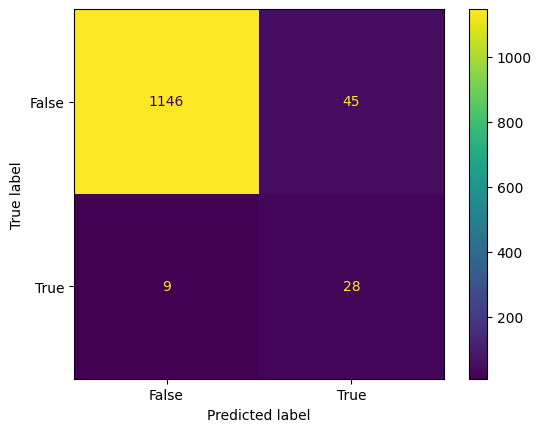

In [67]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_gb_sm, X_test, y_test);

In [68]:
# Print classification report
#classification_report(y_test, model.predict(X_test))
print(classification_report(y_test, model_gb_sm.predict(X_test)))

              precision    recall  f1-score   support

       False       0.99      0.96      0.98      1191
        True       0.38      0.76      0.51        37

    accuracy                           0.96      1228
   macro avg       0.69      0.86      0.74      1228
weighted avg       0.97      0.96      0.96      1228



In [69]:
# Save model
with open("model-gbs.pkl", "wb") as f:
    pickle.dump(model_gb_sm, f)

In [70]:
# make prediction
from predictionfunc import make_predictions

# Generate predictions
y_test_pred = make_predictions(
    data_filepath="taiwan-bankruptcy-data-test-features.json.gz",
    model_filepath="model-gbs.pkl",
)

print("predictions shape:", y_test_pred.shape)
y_test_pred.head()

predictions shape: (682,)


,bankrupt
id,
18,False
20,False
24,False
32,True
38,False
